<h1> Project <h1>


In [37]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import skimage
import scipy
import glob
from skimage.measure import label, regionprops, find_contours
from skimage.transform import hough_circle, hough_circle_peaks,hough_ellipse
from skimage.draw import circle_perimeter,ellipse_perimeter
from skimage.feature import canny
from skimage import io,filters,img_as_ubyte


In [42]:
chemins_images = glob.glob("dataset/*.jpg")
imgs = [io.imread(chemin_image) for chemin_image in chemins_images]
img = skimage.color.rgb2gray(imgs[3]).astype(float)
t = img.max()/2
mask = img<t

In [43]:
disk = skimage.morphology.disk(20)
square=np.ones((3,3))
img_fill = scipy.ndimage.binary_fill_holes(mask)
#plt.imshow(img_fill, 'gray');

In [44]:
def v1(imgrgb,img):
    props = regionprops(label(img))
    centroids = [region.centroid for region in props if region.area > 5 and region.eccentricity < 0.9]
    bbox = [region.bbox for region in props if region.area > 5 and region.eccentricity < 0.9]
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(imgrgb,'gray')
    for c, box in zip(centroids,bbox):
        minr, minc, maxr, maxc = box
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                    fill=False, edgecolor='red', linewidth=0.8)
        cy,cx = c
        ax.add_patch(rect)
        ax.plot(cx,cy,'b+')
    plt.tight_layout()
    plt.show()
    #return centroids,bbox;

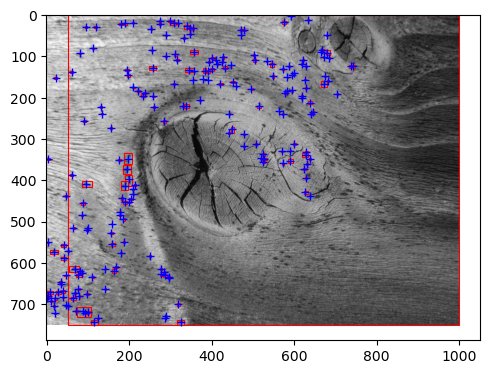

In [45]:
v1(img,img_fill)

### Informations à priori sur un nœud :

- **Forme :** Ellipse ou cercle.
- **Couleur :** Plus sombre que l'ensemble des pixels de l'image.
- **Variation de couleur :** Généralement uniforme dans toutes les directions autour du nœud.

### Défauts de la méthode actuelle :

- Le seuil est statique.
- La surface d'un nœud est statique.
- L'excentricité est statique.

### Idées de solutions :

- Explorer les propriétés des éléments de `regionprops`.
- Définir des métriques basées sur les informations spécifiques de chaque image telles que min, max, variance, etc.
- Utiliser la détection d'ellipse ou de cercle avec la méthode de Hough pour éliminer certaines zones.
- Envisager d'inclure la variation des pixels (gradient) autour d'un nœud pour sa détection.

### Perspectives avancées :

- Prendre en compte la variation de pixels (gradient) autour d'un nœud

<h2> 2.0 <h2>

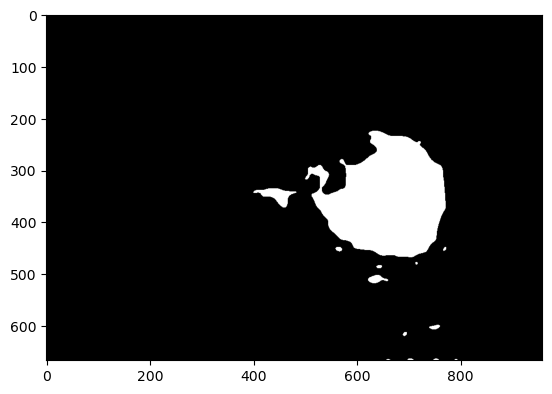

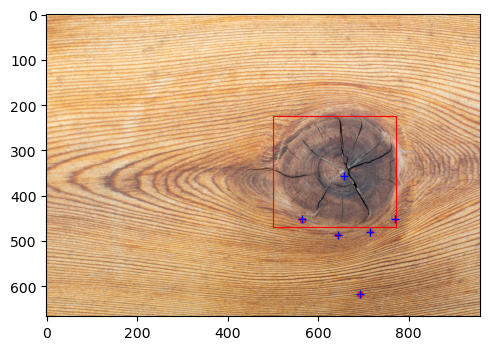

In [47]:
#img_closing = img_closing = skimage.morphology.binary_closing(mask, footprint=skimage.morphology.disk(5))
#plt.imshow(img_closing,'gray')
imgrgb = imgs[5]
img_ =  skimage.color.rgb2gray(imgrgb).astype(float)
t = img_.max()/2
sigma_value = 6
gaussian_img = filters.gaussian(img_, sigma=sigma_value)
mask1 = gaussian_img<t
img_fill_ = scipy.ndimage.binary_fill_holes(mask1)
#img_closing = img_closing = skimage.morphology.binary_closing(mask1, footprint=skimage.morphology.disk(5))
edges = canny(mask1, low_threshold=0.5*img.max(), high_threshold=0.9*img.max())
plt.imshow(img_fill_,'gray')
v1(imgrgb,img_fill_)

### Constats
l'ajout d'un filtre gaussien permet d'uniformiser les couleurs et ainsi élimise les zones sombres de l'image qui pourrait être confondues à des noeuds

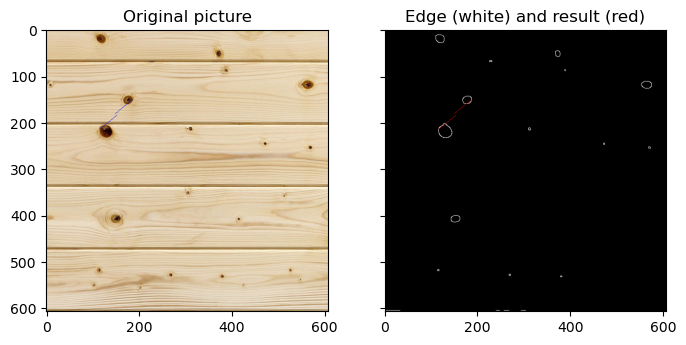

In [186]:
# Paramètres pour la transformation de Hough elliptique
min_semiaxis = 5
max_semiaxis = 100
threshold = 0.1

# Appliquer la transformation de Hough elliptique
result = hough_ellipse(edges, 
                       min_size=min_semiaxis, max_size=max_semiaxis)
result.sort(order='accumulator')

# Estimated parameters for the ellipse
best = list(result[-1])
yc, xc, a, b = (int(round(x)) for x in best[1:5])
orientation = best[5]

# Draw the ellipse on the original image
cy, cx = ellipse_perimeter(yc, xc, a, b, orientation)
imgrgb[cy, cx] = (0, 0, 255)
# Draw the edge (white) and the resulting ellipse (red)
edges = skimage.color.gray2rgb(img_as_ubyte(edges))
edges[cy, cx] = (250, 0, 0)

fig2, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(8, 4),
                                sharex=True, sharey=True)

ax1.set_title('Original picture')
ax1.imshow(imgrgb)

ax2.set_title('Edge (white) and result (red)')
ax2.imshow(edges)

plt.show()
